# Train: 機械学習モデルを学習する

## なにをするのか

Preprocessで用意したデータを用い、機械学習モデルを学習します。

## なぜやるのか

Testで機械学習モデルの有用性を検証するために、学習済みの機械学習モデルが必要です。

## どうやるのか

Business Understandingで定めた機械学習の用途と、データに合わせた機械学習モデルを選択し、学習します。モデルの選択と学習をプログラミング演習で行います。用途には次のようなものがあるはずです。

* 二値分類
* 多クラス分類
* 回帰

### プログラミング演習

モデルの選択、モデルの学習、学習のチューニングの3段階で進めます。高性能なライブラリやAuto MLの登場により自分でモデルを選択する機会自体が少なくなりつつありますが、`scikit-learn`で提示されているモデル選択のマップは有用です。

<img src="./images/05_train_001.PNG" alt="05_train_001.PNG" width=700></img>

今回は`ElasticNet`/`Lasso`に該当します。モデルの違いについては本章で詳しくは触れませんが、`Lasso`の特性も含む`ElasticNet`を採用します。

学習するため、前処理済みのデータを読み込みます。

In [1]:
from pathlib import Path
import pandas as pd


train_data_path = Path("../data/processed/train.csv")
train_df = pd.read_csv(train_data_path)

In [2]:
train_df

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,MSZoning,MasVnrType,Neighborhood,PavedDrive,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
0,0.169526,-0.635811,-1.237244,-0.572238,-1.520166,1.280572,-1.829724,0.249044,-0.575503,-0.540152,...,4.0,2.0,9.0,2.0,1.0,1.0,4.0,8.0,1.0,0.0
1,-1.146860,3.146650,-0.042105,-0.137042,-0.070070,2.179252,-2.028419,-1.688593,-0.575503,-0.972807,...,4.0,2.0,17.0,2.0,1.0,1.0,4.0,8.0,1.0,0.0
2,0.240682,2.437439,-1.649361,-0.734610,0.654978,-0.516787,1.117586,0.975658,-0.575503,-0.972807,...,1.0,2.0,21.0,2.0,1.0,1.0,4.0,8.0,1.0,0.0
3,-0.957111,1.491823,-1.566938,0.033750,1.380027,-0.516787,0.720196,0.394367,-0.575503,2.582869,...,3.0,2.0,24.0,2.0,1.0,1.0,4.0,2.0,1.0,0.0
4,0.729287,0.073400,-0.042105,-0.127219,1.380027,-0.516787,0.985122,0.830335,1.638176,-0.972807,...,3.0,1.0,5.0,2.0,1.0,1.0,4.0,8.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,-0.565753,-0.163004,0.370012,-0.102162,-0.070070,1.280572,-1.001828,-1.688593,-0.575503,-0.087731,...,3.0,2.0,12.0,2.0,1.0,1.0,4.0,8.0,1.0,0.0
1017,0.866855,-0.872215,0.328801,-0.119501,-0.070070,-0.516787,1.150701,1.024099,-0.575503,-0.920098,...,3.0,2.0,5.0,2.0,1.0,1.0,4.0,8.0,1.0,0.0
1018,0.496844,0.309804,-0.042105,1.361190,0.654978,1.280572,-1.034944,-1.688593,-0.575503,-0.972807,...,3.0,2.0,4.0,2.0,1.0,1.0,4.0,0.0,1.0,0.0
1019,0.273888,0.664410,-0.042105,0.615182,-0.795118,-0.516787,0.124111,-0.186924,-0.575503,2.079935,...,3.0,2.0,19.0,2.0,1.0,1.0,4.0,8.0,1.0,0.0


モデルの学習を行います。`scikit-learn`では`fit`するだけです。学習結果は、モデルのパラメーター(`ElasticNet`であれば`l1_ratio`など)にも大きく依存します。場合によってハイパーパラメーターの調整も行う必要があります。

* モデルのパラメーター: モデルが持つパラメーター。`ElasticNet`であれば`l1_ratio`など
* 最適化のパラメーター: SGDであれば学習率など
* データのパラメーター: Data Augmentationの種別など

In [3]:
from sklearn.linear_model import ElasticNet


X = train_df.drop("SalePrice", axis=1)
y = train_df["SalePrice"]
model = ElasticNet(l1_ratio=0.3)
model.fit(X, y)

ElasticNet(l1_ratio=0.3)

`ElasticNet`は線形のモデルのため、個別の特徴量に対し重みをもちます。重みを確認してみましょう。

<AxesSubplot:>

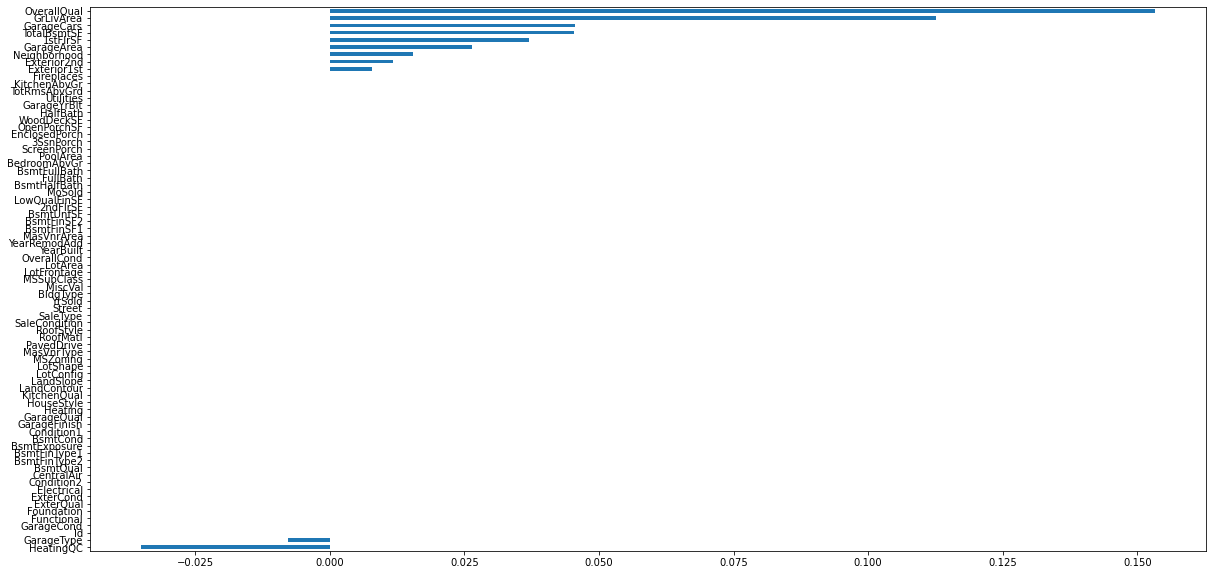

In [4]:
pd.Series(model.coef_, index=model.feature_names_in_).sort_values().plot.barh(figsize=(20, 10))

Analyzeの結果が示唆するように、OverallQualに重みがかかっていることが読み取れます。

*Exercise: 他のモデルでも学習してみましょう。 例: RandomForestRegressor*

In [5]:
from sklearn.ensemble import RandomForestRegressor


other_model = RandomForestRegressor(n_estimators=20, max_features='auto')
other_model.fit(X, y)

RandomForestRegressor(n_estimators=20)

<AxesSubplot:>

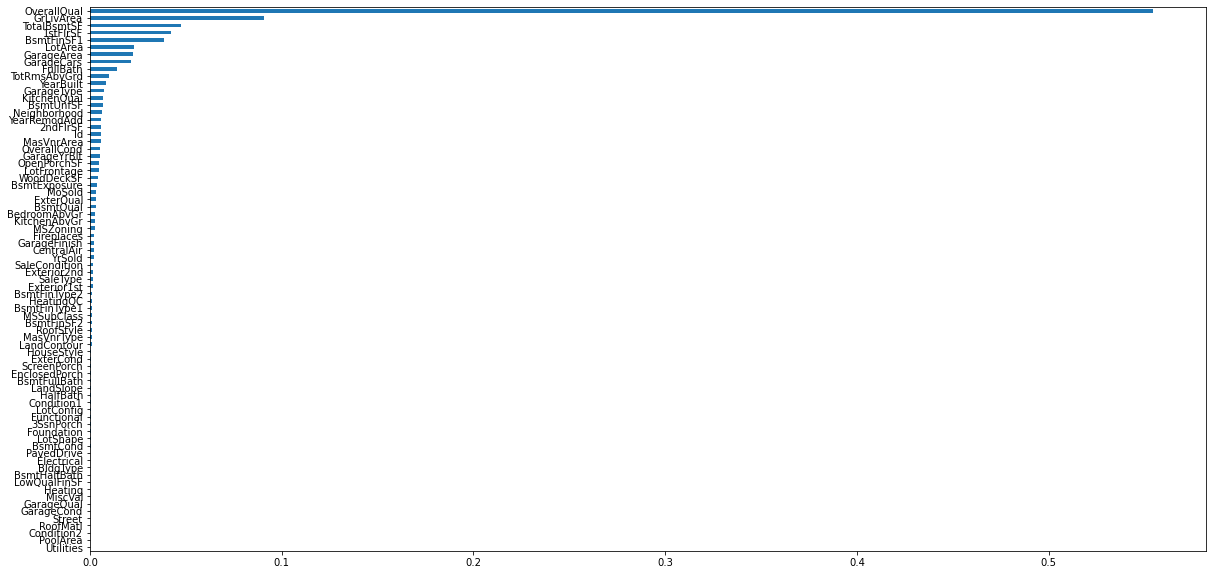

In [6]:
pd.Series(other_model.feature_importances_, index=X.columns).sort_values().plot.barh(figsize=(20, 10))

分析はTestで行いましょう。モデルを保存します。

In [8]:
from joblib import dump


# 2つとも保存します。
model_dict = {"model": model, "other_model": other_model}
for model_name in model_dict:
    model_path = Path(f"../model/{model_name}.joblib")
    dump(model_dict[model_name], model_path)

### コミュニケーション演習

プログラミング演習で次の手順で機械学習モデルの学習を行いました。学習の妥当性を確認するために誰に何を依頼すべきでしょうか。

* モデルの選択
* モデルの学習

ロールの種別

| 英語名             | 日本語名                   | 役割                                                                 |
|--------------------|----------------------------|------------------------------|
| Product Manager    | プロダクトマネージャー     | ユーザー体験を向上させるために実装すべきソフトウェア機能を定義する。 |
| Business Analyst   | ビジネスアナリスト         | 解決すべきビジネス上の問題を定義する                                 |
| Data Analyst       | データアナリスト           | データの可視化と分析で問題を定量的に特定する。                       |
| Architect          | アーキテクト               | ソフトウェアアーキテクチャ全体を設計する。                           |
| DevOps Engineer    | DevOpsエンジニア           | ソフトウェアの開発・運用プロセスを自動化する。                       |
| Software Engineer  | ソフトウェアエンジニア     | ソフトウェアの開発を行う。                                           |
| Operator           | 業務担当者                 | ソフトウェアを利用し業務を行う。                                     |
| System Admin       | システム管理者             | サービスの挙動を監視する。                                           |
| IT Auditor         | IT監督者                   | システムや会社全体の権限管理や監査を行う。                           |
| Data architect     | データアーキテクト         | データを管理する基盤を設計、運用する。                               |
| Domain Expert      | 業務有識者                 | 深い業務知識を持ちデータの意味やあるべき状態について定義する。       |
| Data Scientist     | データサイエンティスト     | 機械学習モデルを開発する。     

依頼の種別

* 情報共有: 開発に必要な情報/ドキュメントの提供を依頼する
* 作業: 開発に必要な作業を分担(依頼)する
* レビュー: 作業の確度を上げるため/承認を得るためレビューを依頼する


#### MLOpsチームへの依頼例

Data Scientistがいれば、次の依頼をするとよいでしょう。

* レビュー
   * モデルの選択、学習方法が適切か。

## AWS Empowerment

AWSでは、モデルの学習を行うためのマネージドサービスを提供しています。サービスを利用していただくことで、効率的な学習とチューニングが可能になります。

* [Amazon SageMaker Autopilot](https://aws.amazon.com/jp/sagemaker/autopilot/)
   * モデルの選択から学習、重要な特徴の評価まで自動で行ってくれます。作成したモデルのNotebookを生成できるため、ベースラインとなるモデルをサッと作成しあとは手動でチューニングするという使い方ができます。
* [Amazon SageMaker Jumpstart](https://aws.amazon.com/jp/sagemaker/jumpstart/)
   * ビルトインのアルゴリズムや事前学習済みモデルを選択し(転移)学習が素早く行えます。
* [Amazon SageMaker Model Training](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-training.html)
   * Training Jobを使ってモデルをトレーニングします。Training Jobはコンテナベースで処理を行い、データの場所(S3)、学習に使うコンピューティングインスタンス(EC2)、学習に使うコンテナ、学習後の結果出力先(S3)の4つを指定し起動します。学習が完了したら勝手に止まるため無駄がありません。
   * ML Enablement Series [Amazon SageMaker Training で機械学習のモデル開発を楽にする【ML-Dark-01】【AWS Black Belt】](https://youtu.be/byEawTm4O4E)をご参照ください。
* [Amazon SageMaker Debugger](https://aws.amazon.com/jp/sagemaker/debugger/)
   * 学習中のGPU/CPU使用率といったコンピューティングリソースの使用料、勾配の状況などをプロファイルしアラートを上げることができます。

## Next Step

[Test](06_test.ipynb)

## References

1. Sebastian Raschka, Vahid Mirjalili, 株式会社クイープ and 福島 真太朗. [Python機械学習プログラミング 達人データサイエンティストによる理論と実践 ](https://www.amazon.co.jp/dp/4844380605). 2020.
